# ------------------- Titanic Machine Learning Competition -------------------
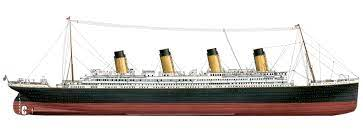

[img source](https://www.google.com/imgres?imgurl=https%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2Fa%2Fa3%2FTitanic_Stardboard_Side_Diagram.jpg&imgrefurl=https%3A%2F%2Fcommons.wikimedia.org%2Fwiki%2FFile%3ATitanic_Stardboard_Side_Diagram.jpg&tbnid=GwertQ_rt9kJgM&vet=12ahUKEwiD4-eWjPb1AhVzqnIEHVPhDHsQMygBegUIARCJAg..i&docid=tMsLPtCu8Kue8M&w=4096&h=1569&q=titanic&hl=en&safe=images&ved=2ahUKEwiD4-eWjPb1AhVzqnIEHVPhDHsQMygBegUIARCJAg)
 

#### About:
My purpose for entering this challenge is to learn and practice my data analysis skills. In this competition, we use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. The full details of the competition are at https://www.kaggle.com/c/titanic.

#### Skill Learnt:
- Python basics
- Data cleaning
- Explore data
- Analysis data 
- Feature engineering

#### The Challenge:
On April 15, 1912, the widely considered "unsinkable" RMS Titanic sank after colliding with an iceberg during her maiden voyage. Unfortunately, there weren't enough lifeboats for everyone on board, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, I need to build a predictive model that answers the question: "what sorts of people were more likely to survive?" using our given data set. 

#### Data Used:
I have access to two similar datasets in this competition, including passenger information listed below under the "Variable Descriptions." One dataset is titled train.csv, and the other is titled test.csv.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact), and we will reveal whether they survived or not.

The test.csv dataset contains similar information but does not disclose whether each passenger survived. It's my job to predict these outcomes.

Using the patterns I find in the train.csv data, I must predict whether the other 418 passengers onboard (found in test.csv) survived.

#### Variable Descriptions:
- Passenger: unique id number to each passenger
- Survived: passenger survive(1) or died(0)
- P-class: passenger class
- Name: name
- Sex: gender of the passenger
- Age: age of passenger
- SibSp: number of siblings/spouses
- Parch: number of parents/children
- Ticket: ticket number
- Fare: the amount of money spent on the ticket
- Cabin: cabin category
- Embarked: port where passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton)

#### Import Necessary Libraries

In [1]:
# Required python packages:
 
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

#### Read In and Explore the Data

In [2]:
# Importing dataset:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("../input/titanic/test.csv")

In [3]:
# Percent of passengers that survived in our training data set vs percent of total survivors
y = train_data["Survived"].copy()
print('Train sample:    ', (sum(y)/len(y))*100, '%')
print('Total passanger: ', ((2224-1502)/2224)*100, '%')

Train sample:     38.38383838383838 %
Total passanger:  32.46402877697842 %


38% of passengers survived in the training data set, and only 32% survived out of the total passengers in the ship. To get the best score in the competition, we may need to adjust our model to be more pessimistic with its predicted outcome. 

In [4]:
# Prevewing the values in each feature
print(train_data.apply(lambda col: col.unique()))

PassengerId    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Survived                                                  [0, 1]
Pclass                                                 [3, 1, 2]
Name           [Braund, Mr. Owen Harris, Cumings, Mrs. John B...
Sex                                               [male, female]
Age            [22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...
SibSp                                      [1, 0, 3, 4, 2, 5, 8]
Parch                                      [0, 1, 2, 5, 3, 4, 6]
Ticket         [A/5 21171, PC 17599, STON/O2. 3101282, 113803...
Fare           [7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....
Cabin          [nan, C85, C123, E46, G6, C103, D56, A6, C23 C...
Embarked                                          [S, C, Q, nan]
dtype: object


There appear to be some missing values in the features "Age," "Cabin," and "Embarked."  The features "PassengerID," "Name," and "Ticket" are of no use in building our model. 

# Cleaning Data

In [5]:
# Remove useless features 
train_data.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
test_data.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [6]:
#  Selecting features with missing values 
NA = [(c, train_data[c].isna().mean()*100) for c in train_data]
NA = pd.DataFrame(NA, columns=["column_name", "percentage"])

# Display the percentage of missing values in each feature 
NA = NA[NA.percentage > 0]
NA.sort_values("percentage", ascending=False)

,column_name,percentage
7,Cabin,77.104377
3,Age,19.865320
8,Embarked,0.224467


We will discard the " Cabin " feature since it is missing most of its values. We will replace the missing values in features "age" and "Embarked" with mean values in each feature.

In [7]:
# Remove the "Cabin" feature from the data sets
train_data.drop(['Cabin'], axis=1, inplace=True)
test_data.drop(['Cabin'], axis=1, inplace=True)

# Select the remaining features to replace with the most frequent value (mean value)
columns_low_NA = ['Age', 'Embarked']

# Fill missing values for each feature with it's mean value
train_data[columns_low_NA] = train_data[columns_low_NA].fillna(train_data.mode().iloc[0])
test_data[columns_low_NA] = test_data[columns_low_NA].fillna(test_data.mode().iloc[0])

#### Data Analysis

<AxesSubplot:xlabel='Sex', ylabel='count'>

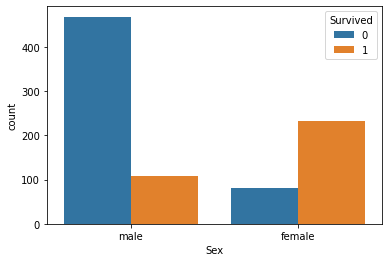

In [8]:
# Survival chart for comparison of each sex
sns.countplot(x="Sex", hue="Survived", data=train_data)

There are about twice as many female survivors as male survivors and nearly twice as many male passengers as female passengers. This feature looks like it could have high importance in our model. 

<AxesSubplot:xlabel='Parch', ylabel='count'>

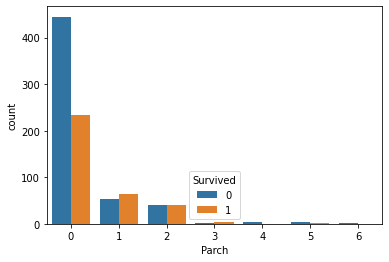

In [9]:
# Survival chart for comparison for the "Parch" feature
sns.countplot(x="Parch", hue="Survived", data=train_data)

Having one, two or three parents or children increases the chance of survival well zero or more the three children decrease the chance of survival. There is no strong pattern, so this feature will likely have low importance. 

<AxesSubplot:xlabel='SibSp', ylabel='count'>

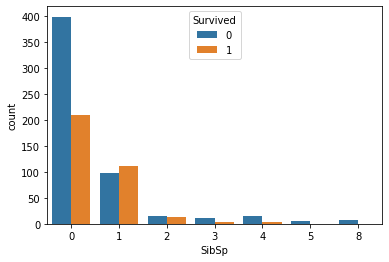

In [10]:
# Survival chart for comparison for the "SibSp" feature
sns.countplot(x="SibSp", hue="Survived", data=train_data)

Having one, two siblings and or spouse increases the chance of survival well zero or more the two children decrease the chance of survival. There is no strong pattern, so this feature will likely have low importance. 

In [11]:
# Percent of survival for each variable in "Embarked"
Embarked = train_data[['Embarked', 'Survived']].groupby([
    'Embarked'], as_index=False).mean().sort_values(
        by='Survived', ascending=False)
print(Embarked)

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


Each variable in "Embarked" has roughly a 10% difference in survival rate which means this feature will likely have low importance in our model.

In [12]:
# Percent of survival for each variable in "Pclass"
Pclass = train_data[['Pclass', 'Survived']].groupby([
    'Pclass'], as_index=False).mean().sort_values(
        by='Survived', ascending=False)
print(Pclass)

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


Each variable in "Pclass" has, on average, roughly a 20% difference in survival rate which means this feature will likely have moderate importance in our model.

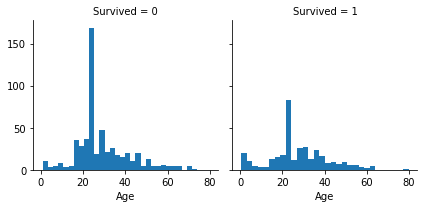

In [13]:
# Survival chart for comparison of the "Age" feature
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=30)

There is no strong pattern for the passager age survival rate, so this feature will likely have low importance in our model. 

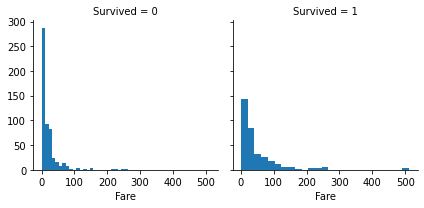

In [14]:
# Survival chart for comparison of the "Fare" feature
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Fare', bins=25)

There is no strong pattern for the passager's fare price, so this feature will likely have low importance in our model. 

# Prossesing The Data

In [15]:
# Feature mapping for the feature "Pclass"
Pclass =   {1 : 'PclassA', 2 : 'PclassB', 3 : 'PclassC'}
train_data['Pclass'] = train_data['Pclass'].map(Pclass)
test_data['Pclass'] = test_data['Pclass'].map(Pclass)

In [16]:
# Changing feature "sex" from categorical to numerical 
sex_bin = {"female": 0,   # Zero is female 
           "male": 1}     # One is for male
train_data['Sex'] = train_data['Sex'].map(sex_bin)
test_data['Sex'] = test_data['Sex'].map(sex_bin)

In [17]:
# One-hot encoding for the features "Embarked" and "Pclass"
train_encoded = pd.get_dummies(train_data, columns=['Embarked', 'Pclass'])
test_encoded = pd.get_dummies(test_data, columns=['Embarked', 'Pclass'])

# Building The Model

In [18]:
# Drop the target variable for testing
X = train_encoded.drop(['Survived'], axis=1).copy()

# Split data into training and validation data, for both features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
X, y = make_classification(random_state=0)

In [19]:
# Set up model with XGboost 
model = xgb.XGBClassifier(seed=0,
                      max_depth=6,
                      subsample=1,
                      n_estimators=100,
                      learning_rate=0.3,
                      min_child_weight=1,
                      random_state=5,
                      reg_alpha=0,
                      reg_lambda=1,
                      use_label_encoder=False)
# Fit the model
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
# Print test and training accuracy scores
print('Train accurcy', (accuracy_score(y_train, y_train_predict))*100, '%')
print('Test accurcy ', (accuracy_score(y_test, y_predict))*100, '%')

[03:02:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accurcy 97.75449101796407 %
Test accurcy  83.85650224215246 %


Text(0.5, 1.0, 'confusion Matrix Diagram')

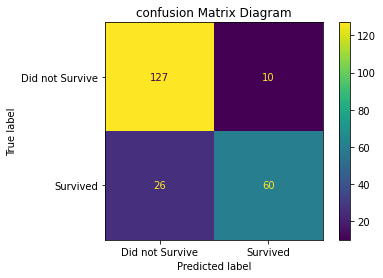

In [20]:
# Confusion Matrix Diagram
plot_confusion_matrix(model, X_test, y_test, display_labels=["Did not Survive", "Survived"])
plt.title("confusion Matrix Diagram")

We have 26 false non-survival predictions in our confusion matrix and only 10 false survived predictions. We want this since our training data had a high percentage of survivors than the actual survivors on the ship. 

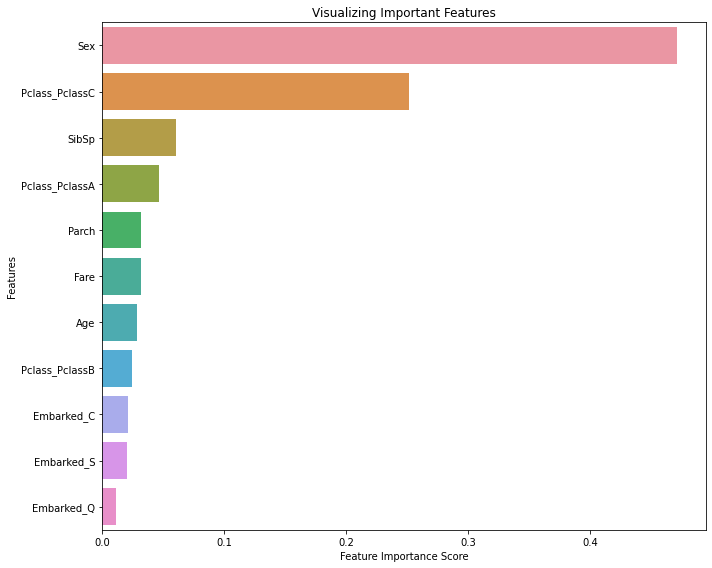

In [21]:
# Plot to visualize importance of each feature
feature_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

Text(0.5, 1.0, 'Plot of Single Tree in our Model')

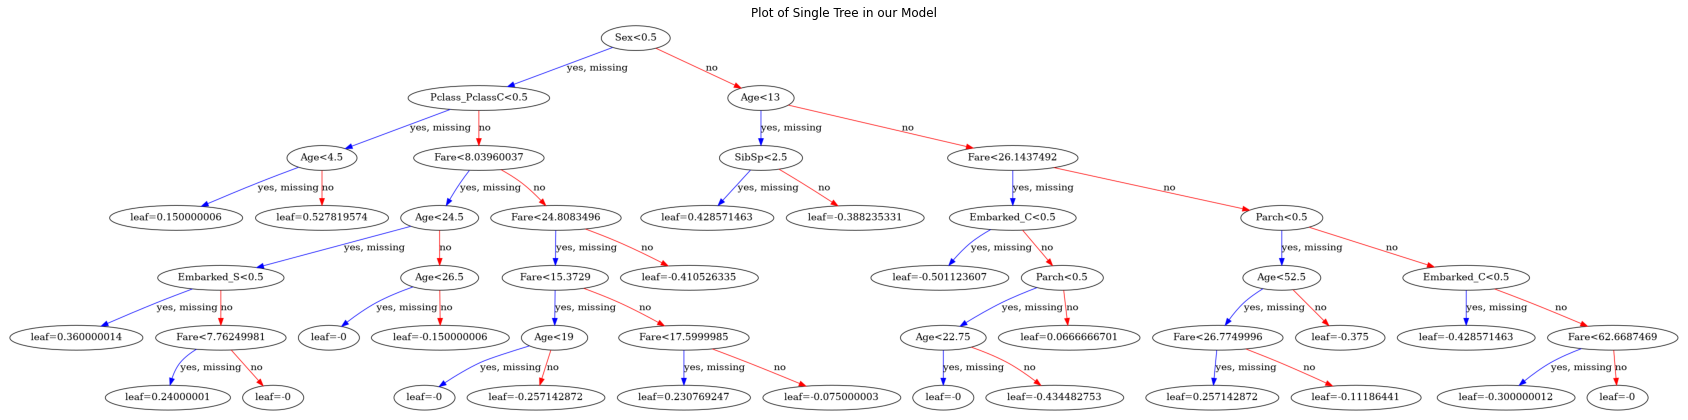

In [22]:
# Plot of single tree
plot_tree(model, num_trees=0)
plt.gcf().set_size_inches(30, 30)
plt.title("Plot of Single Tree in our Model")

# Making my prediction

In [23]:
# Using our model to make a prediction
test = test_encoded.copy()
predictions = model.predict(test)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [24]:
# Submitting prediction
submit=pd.read_csv('../input/titanic/gender_submission.csv')
submit['Survived']=predictions
submit.to_csv('submission.csv', index=False)
print(submit)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


Our submission to the competition resulted in a 77.5 percent accuracy on the survivours. Which I'm happy with for a first attempt. Any suggestions to improve our score are welcome.